In [1]:
import matplotlib.pyplot as plt

from platform import python_version
from scipy import stats

import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
import matplotlib

import timeit
from tqdm import tqdm
import random
import os

# import preprocessing tools 
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression as mi
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score as R2

# import gaussian process model 
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

In [2]:
print(os.listdir('DATA'))

train = pd.read_csv("DATA/train.csv").dropna(axis=1)
test = pd.read_csv("DATA/test.csv")

target = np.array(train['SalePrice'].values, np.float)

train.head()

['data_description.txt', 'house-prices-advanced-regression-techniques.zip', 'sample_submission.csv', 'test.csv', 'train.csv']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [3]:
# Neighborhood is an important categorical, nominal feature 
# want to do the ordinal encoding manually 
def OrdinalEncoder(df, features, target='SalePrice'):
    # loop through all categorical features 
    for feature in features:
        neighborhoods = df[feature].values
        prices = []
        # for each feature, determine avg target value
        for neighborhood in np.unique(neighborhoods):
            inds = neighborhood == neighborhoods
            prices.append(np.mean(df.iloc[inds, :][target].values))
        ordinal_labels = np.argsort(prices)
        prices_dict = {neighborhood:i for i, neighborhood in enumerate(np.unique(neighborhoods)[ordinal_labels])}
        # encode categorical features ordinally based on target values 
        encoded_neighborhood = [prices_dict[n] for n in neighborhoods]
        df[feature] = encoded_neighborhood
    return df

In [4]:
# pull out categorical and continuous features 
continuousfeatures = train.describe().columns.values[1:-1] 
categoricalfeatures = [ftr for ftr in train.columns.values[1:-1] if ftr not in continuousfeatures]
features = list(continuousfeatures) + categoricalfeatures

# Assume categorical features are ordinal and encode 
train = OrdinalEncoder(train, categoricalfeatures)

# take decades since 2020 for features that describe the year 
yearfeatures = [f for f in features if 'Year' in f or 'Yr' in f]
train[yearfeatures] = (2020 - train[yearfeatures].values)/ 10

# take square root of features that describe area and divide by max 
areafeatures = [f for f in features if 'SF' in f or 'Area' in f]
train[areafeatures] = train[areafeatures].values**.5 / np.max(train[areafeatures].values**.5, 0)

# set up training data 
X = np.array(train[features].values, np.float)
y = np.array(train['SalePrice'].values, np.float)

# center data 
X = MinMaxScaler((-1, 1)).fit(X).transform(X)

# actually predict centered log_y 
y = np.log(y) - np.mean(np.log(y))

# set up a dataframe with features and target variables 
train[features] = X 
train['SalePrice'] = y
X_df = train[features]
y_df = train['SalePrice']

In [5]:
def HyperParamOpt2D(X, y, classifier, hyperparams1, hyperparams2, n_splits):
    # init list of oof prediction performances 
    oof_performance = np.zeros([len(hyperparams1), len(hyperparams2)])
    
    # loop over hyperparameters 
    for i, hyperparam1 in enumerate(hyperparams1):
        for j, hyperparam2 in enumerate(hyperparams2):
            # set up out of fold 
            oof = np.zeros(X.shape[0])

            # pull each subset for training 
            skf = KFold(n_splits, shuffle=True)
            skf.get_n_splits(X, y)
            for train_index, val_index in skf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                # init classifier 
                clf = classifier(alpha=hyperparam1, kernel=RBF(hyperparam2))
                clf.fit(X_train, y_train)
                # make predictions 
                oof[val_index] = clf.predict(X_val).flatten()
            
            # calculate mse 
            mse = np.linalg.norm(oof - y)
            R2score = -R2(oof, y)
            oof_performance[i, j] = R2score
    
    # choose best weights from validation performance
    i_best, j_best = np.unravel_index(oof_performance.argmin(), oof_performance.shape)
    best_param1 = hyperparams1[i_best]
    best_param2 = hyperparams2[j_best]
    
    # fit best model 
    best_clf = classifier(alpha=best_param1, kernel=RBF(best_param2))
    best_clf.fit(X, y)
    
    return best_clf, best_param1, best_param2

In [8]:
# set up training params
n_splits_1 = 24
n_splits_2 = 6

# set up out of fold predictions
oof = np.zeros(len(X_df))

# set hyperparams to optimize over 
hyperparams1 = np.logspace(-4, np.log10(20), 20)
hyperparams2 = np.linspace(1, 10, 20)

# split data into 10 train+validation and testing data sets
skf1 = KFold(n_splits=n_splits_1, shuffle=True, random_state=123)
skf1.get_n_splits(X_df, y_df)
for trainval_index, test_index in tqdm(skf1.split(X_df)):
    # split the whole dataset into training+validation data and testing sets
    X_trainval, X_test = X[trainval_index], X[test_index]
    y_trainval, y_test = y[trainval_index], y[test_index]
    
    ### Kernel Ridge ###
    # see what hyperparameter performs best on validation data 
    best_model, best_param1, best_param2 = HyperParamOpt2D(X_trainval, y_trainval, KernelRidge, 
                                                           hyperparams1, hyperparams2, n_splits=n_splits_2)
    print(best_param1)
    print(best_param2)

    # make predictions 
    y_pred_test = best_model.predict(X_test)

    # store predictions
    oof[test_index] = y_pred_test.flatten()

1it [06:06, 366.50s/it]

0.032435022868815847
5.263157894736842


2it [12:13, 366.57s/it]

0.11722422384602046
4.789473684210526


3it [18:29, 369.37s/it]

0.004720733374537327
9.526315789473683


4it [24:38, 369.38s/it]

0.008974516307162747
9.526315789473683


5it [30:50, 370.15s/it]

0.01706132004445682
8.105263157894736


6it [37:00, 370.17s/it]

0.032435022868815847
7.157894736842105


7it [43:06, 368.81s/it]

0.032435022868815847
7.63157894736842


8it [49:12, 368.12s/it]

0.061661741633081184
5.263157894736842


9it [55:18, 367.41s/it]

0.032435022868815847
5.7368421052631575


10it [1:01:27, 367.85s/it]

0.01706132004445682
8.105263157894736


11it [1:07:34, 367.46s/it]

0.032435022868815847
7.157894736842105


12it [1:13:43, 368.13s/it]

0.01706132004445682
6.684210526315789


13it [1:19:56, 369.49s/it]

0.032435022868815847
6.684210526315789


14it [1:26:07, 370.06s/it]

0.032435022868815847
5.7368421052631575


15it [1:32:04, 366.10s/it]

0.061661741633081184
4.315789473684211


16it [1:37:58, 362.28s/it]

0.061661741633081184
4.789473684210526


17it [1:43:56, 361.10s/it]

0.01706132004445682
7.63157894736842


18it [1:49:52, 359.64s/it]

0.008974516307162747
7.63157894736842


19it [1:55:46, 357.94s/it]

0.061661741633081184
6.684210526315789


20it [2:01:41, 357.09s/it]

0.008974516307162747
8.578947368421051


21it [2:07:52, 361.19s/it]

0.032435022868815847
6.2105263157894735


22it [2:14:09, 365.84s/it]

0.008974516307162747
10.0


23it [2:20:23, 368.37s/it]

0.008974516307162747
9.052631578947368


24it [2:26:34, 366.44s/it]

0.01706132004445682
8.105263157894736


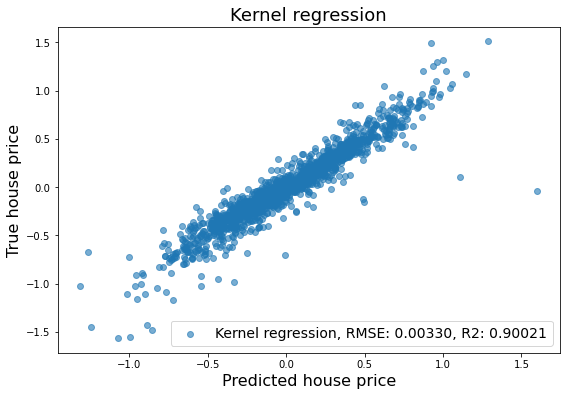

In [9]:
# calculate performance
mse = np.linalg.norm(y - oof)/len(y)
R2 = r2_score(y, oof)

plt.figure(figsize=(9, 6))

plt.scatter(oof, y, alpha=.6, label="Kernel regression, RMSE: {:.5f}, R2: {:.5f}".format(mse, R2))
plt.xlabel("Predicted house price", fontsize=16)
plt.ylabel("True house price", fontsize=16)

plt.legend(fontsize=14)
plt.title("Kernel regression", fontsize=18)
plt.savefig("Figures/KernelRegression.png", dpi=150)
plt.show()